<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

### Datos
Utilizaremos como dataset la biblia.

In [7]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv("/biblia.txt", sep = '/n', header = None)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0
0,In the beginning God created the heaven and th...
1,"And the earth was without form, and void; and ..."
2,"And God said, Let there be light: and there wa..."
3,"And God saw the light, that it was good: and G..."
4,"And God called the light Day, and the darkness..."


In [8]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 31102


### 1 - Preprocesamiento

In [9]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [55]:
# Demos un vistazo
len(sentence_tokens)

31102

In [67]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [74]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [70]:
lemmatizer = WordNetLemmatizer()
lem_sentence_tokens = []
for i in range(len(sentence_tokens)):
  sentence = []
  for word in sentence_tokens[i]:    
    sentence.append(lemmatizer.lemmatize(word))
  lem_sentence_tokens.append(sentence)

In [75]:
stop_words = set(stopwords.words('english'))

In [76]:
final_sentence = []
for word in lem_sentence_tokens:
  filtered_sentence = [w for w in word if not w.lower() in stop_words]
  final_sentence.append(filtered_sentence)

In [78]:
len(final_sentence)

31102

### 2 - Crear los vectores (word2vec)

In [79]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobracargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            r = loss
            print('Loss after epoch {}: {}'.format(self.epoch, r))
        else:
            r = loss - self.loss_previous_step
            print('Loss after epoch {}: {}'.format(self.epoch, r))
        self.epoch += 1
        self.loss_previous_step = loss

In [90]:
# Crearmos el modelo generador de vectoeres
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count = 5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window = 3,       # cant de palabras antes y desp de la predicha
                     size = 100,       # dimensionalidad de los vectores 
                     negative = 30,    # cantidad de negative samples... 0 es no se usa
                     workers = 1,      # si tienen más cores pueden cambiar este valor
                     sg = 1)           # modelo 0:CBOW  1:skipgram

In [91]:
# Buildear el vocabularui con los tokens
w2v_model.build_vocab(final_sentence)

In [92]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 31102


In [93]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.vocab))

Cantidad de words distintas en el corpus: 4765


### 3 - Entrenar el modelo generador

In [94]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
loss_vector = w2v_model.train(final_sentence,
                 total_examples = w2v_model.corpus_count,
                 epochs = 250,
                 compute_loss = True,
                 callbacks=[callback()]
                 ) 

Loss after epoch 0: 3729064.5
Loss after epoch 1: 2957290.0
Loss after epoch 2: 2813180.5
Loss after epoch 3: 2686332.0
Loss after epoch 4: 2634795.0
Loss after epoch 5: 2582148.0
Loss after epoch 6: 2473352.0
Loss after epoch 7: 2443984.0
Loss after epoch 8: 2426822.0
Loss after epoch 9: 2408134.0
Loss after epoch 10: 2388296.0
Loss after epoch 11: 2380126.0
Loss after epoch 12: 2352616.0
Loss after epoch 13: 2298700.0
Loss after epoch 14: 2291788.0
Loss after epoch 15: 2276392.0
Loss after epoch 16: 2275612.0
Loss after epoch 17: 2260880.0
Loss after epoch 18: 2259704.0
Loss after epoch 19: 2251344.0
Loss after epoch 20: 2246420.0
Loss after epoch 21: 2239816.0
Loss after epoch 22: 2241828.0
Loss after epoch 23: 2239004.0
Loss after epoch 24: 2229084.0
Loss after epoch 25: 2225500.0
Loss after epoch 26: 2230752.0
Loss after epoch 27: 1655852.0
Loss after epoch 28: 921120.0
Loss after epoch 29: 919024.0
Loss after epoch 30: 918168.0
Loss after epoch 31: 915536.0
Loss after epoch 32: 9

In [95]:
loss = pd.read_excel('/loss2.xlsx', header = None)

In [96]:
loss

,0,1
0,0,3729064.5
1,1,2957290.0
2,2,2813180.5
3,3,2686332.0
4,4,2634795.0
...,...,...
245,245,0.0
246,246,0.0
247,247,0.0
248,248,0.0


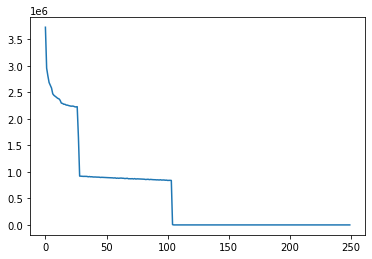

In [97]:
import matplotlib.pyplot as plt

plt.plot(loss.iloc[:, 0], loss.iloc[:, 1])
plt.show()

### 4 - Ensayar

In [98]:
# Palabras que MÁS se relacionan con...:
word = 'god'
w2v_model.wv.most_similar(positive = [word], topn = 10)

[('lord', 0.8805321455001831),
 ('unto', 0.6482241153717041),
 ('therefore', 0.6190711855888367),
 ('thee', 0.6080701351165771),
 ('saying', 0.568709135055542),
 ('u', 0.5509453415870667),
 ('said', 0.5339818000793457),
 ('hath', 0.5295073986053467),
 ('also', 0.5293233394622803),
 ('glory', 0.5219210386276245)]

In [100]:
# Palabras que MENOS se relacionan con...:
word = 'god'
w2v_model.wv.most_similar(negative = [word], topn = 10)

[('mule', 0.05940422788262367),
 ('beard', 0.04812711477279663),
 ('rib', 0.03467540070414543),
 ('wrapped', 0.02631140500307083),
 ('netophathite', 0.026063933968544006),
 ('trode', 0.02468719519674778),
 ('suckling', 0.01718207821249962),
 ('cluster', 0.01681249961256981),
 ('jezreel', 0.012351945042610168),
 ('immer', 0.01193089410662651)]

In [101]:
# Palabras que MÁS se relacionan con...:
word = 'jesus'
w2v_model.wv.most_similar(positive = [word], topn = 10)

[('peter', 0.60768723487854),
 ('disciple', 0.5609852075576782),
 ('christ', 0.5470683574676514),
 ('paul', 0.516880452632904),
 ('john', 0.5107923746109009),
 ('pilate', 0.4932810068130493),
 ('nathanael', 0.49132445454597473),
 ('baptized', 0.4843342900276184),
 ('god', 0.481915682554245),
 ('spirit', 0.46661442518234253)]

In [102]:
# Palabras que MÁS se relacionan con...:
word = 'good'
w2v_model.wv.most_similar(positive = [word], topn = 10)

[('evil', 0.4881630539894104),
 ('man', 0.4336983561515808),
 ('well', 0.4325893521308899),
 ('delighteth', 0.42923876643180847),
 ('create', 0.42305585741996765),
 ('goodness', 0.4151777923107147),
 ('necessary', 0.4124904274940491),
 ('god', 0.40958383679389954),
 ('truth', 0.4094000458717346),
 ('thing', 0.40932419896125793)]

In [103]:
# Palabras que MÁS se relacionan con...:
word = 'evil'
w2v_model.wv.most_similar(positive = [word], topn = 10)

[('good', 0.4881630539894104),
 ('trouble', 0.4458363652229309),
 ('doings', 0.4430549144744873),
 ('parent', 0.4391653537750244),
 ('slow', 0.4333541989326477),
 ('wicked', 0.4320198595523834),
 ('deceitful', 0.43163400888442993),
 ('wherefore', 0.4290006756782532),
 ('speed', 0.4280222952365875),
 ('destruction', 0.4217584729194641)]

In [104]:
# Palabras que MÁS se relacionan con...:
word = 'sin'
w2v_model.wv.most_similar(positive = [word], topn = 10)

[('sinned', 0.5354009866714478),
 ('iniquity', 0.5281431078910828),
 ('remission', 0.49627751111984253),
 ('guilty', 0.4933604896068573),
 ('nebat', 0.48762112855911255),
 ('trespass', 0.4827388525009155),
 ('warn', 0.46578270196914673),
 ('cleanse', 0.4481271505355835),
 ('forgiven', 0.4431529641151428),
 ('foolishly', 0.4421272575855255)]

In [30]:
# Ensayar con una palabra que no está en el corpus (en vocab):
word = 'python'
w2v_model.wv.most_similar(negative = [word])

KeyError: ignored

### 5 - Visualizar agrupación de vectores

In [105]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model):
    num_dimensions = 2  

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [106]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

MAX_WORDS = 50
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [107]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

MAX_WORDS = 200
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



### Explicación y conclusiones

Se quiso intentar otro modelo. En esta ocasión, se lematizaron las palabras, y se retiraron las stopwords, lo que significó en una reducción de aproximadamente 18% en el vocabulario.

Para sorpresa, el modelo performa peor, en la medida en que las palabras que guardan relación son menos razobales entre sí. Las palabras que en el anterior modelo resultaron muy bien, en esta oportunidad arrojan similitudes no muy buenas, como 'god' que la relacionan con preposiciones y palabras con poco sentido. De la misma manera, las palabras con relación opuesta son poco acertadas.

Pasando al gráfico en 2D, los resultados tampoco son muy buenos. Hay algunas buenas relaciones cercanas, como 'life' and 'death', 'flesh' y 'blood', 'good' y 'evil', y 'priest' con 'king' y 'prince'.


### Alumno

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.